# Advanced Lane Finding Project

The goals / steps of this project are the following:

- Camera calibration
- Distortion correction
- Color/gradient threshold
- Perspective transform
- Detect lane lines
- Determine the lane curvature
- Plot the lane and curvature on frames
- Test on video

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Compute the camera calibration matrix and distortion 

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## Distortion correction

In [3]:
img_shape = (720, 1280, 3)

In [4]:
# Use cv2.calibrateCamera() and cv2.undistort()
# Only need to calculate once
ret, mtx, dist, rvecs, tvecs = \
    cv2.calibrateCamera(objpoints, imgpoints, img_shape[:2], None, None)

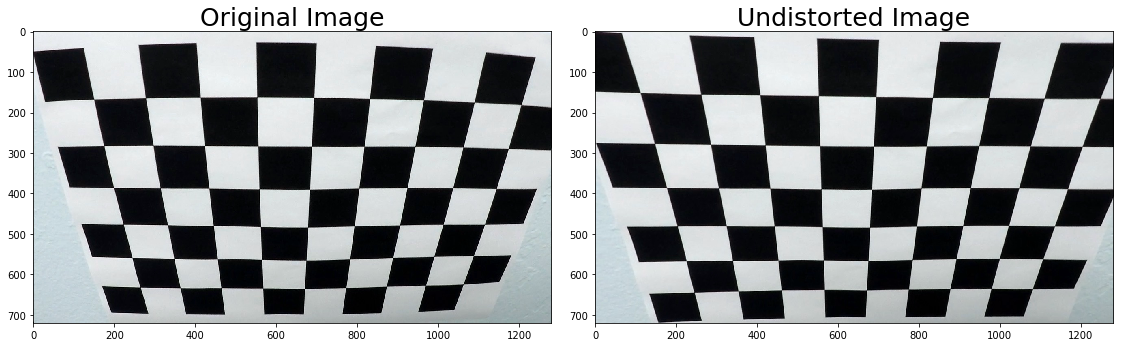

In [25]:
distortion_example_img = cv2.imread('camera_cal/calibration2.jpg')
undistored_example_img = cv2.undistort(distortion_example_img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
f.tight_layout()
ax1.imshow(distortion_example_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistored_example_img)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color/gradient threshold
Find a combination of color and gradient thresholds

#### Absolute Sobel

In [6]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

#### Magnitude

In [5]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

#### Direction

In [6]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#### Color thresholding

In [412]:
# Convert to HLS color space and separate the S channel

def hls_threshold(img, h_thresh=(0, 255), s_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]

    # Threshold color channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > s_thresh[0]) & (h_channel < h_thresh[1]) & (h_channel > h_thresh[0])] = 1

    return binary_output

In [7]:
# Use RGB color space and separate the S channel

def rgb_threshold(img, thresh=(0, 255)):
    red = img[:,:,0]

    # Threshold color channel
    binary_output = np.zeros_like(red)
    binary_output[(red > thresh[0]) & (red < thresh[1])] = 1

    return binary_output

In [15]:
# Use L of Luv for whites
def luv_threshold(img, l_thresh=(0, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    
    # Threshold color channel
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > l_thresh[0]) & (l_channel < l_thresh[1])] = 1

    return binary_output

In [21]:
# Use b of Lab for yellow
def lab_threshold(img, b_thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # b channel max value is 128
    b_channel = lab[:,:,2]
    
    # Threshold color channel
    binary_output = np.zeros_like(b_channel)
    binary_output[(b_channel > b_thresh[0]) & (b_channel < b_thresh[1])] = 1

    return binary_output

#### Combined

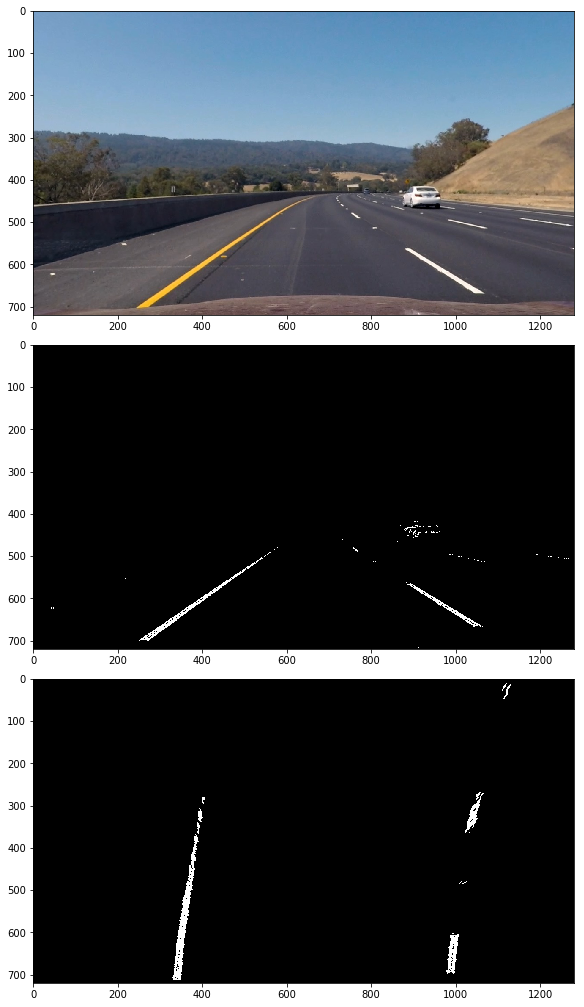

In [199]:
# define the threshold method

def threshold_image(image):
    # Choose a Sobel kernel size
    ksize = 13 # Choose a larger odd number to smooth gradient measurements

    # threshold
    magnitude = (13, 255)
    direction = (0.7, 1.3)
    h = (0, 100)
    s = (100, 255)
    rgb = (100, 255)
    l = (205, 255) # for white lanes
    b = (180, 255) # for yellow lanes

    # Apply each thresholding function
#     mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=magnitude)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=direction)
#     hls_binary = hls_threshold(image, h_thresh=h, s_thresh=s)
#     rgb_binary = rgb_threshold(image, thresh=rgb)
    luv_binary = luv_threshold(image, l_thresh=l)
    lab_binary = lab_threshold(image, b_thresh=b)

    thresholded = np.zeros_like(luv_binary)
#     thresholded[((mag_binary == 1) & (dir_binary == 1)) & ((luv_binary == 1) | (lab_binary == 1))] = 1
    thresholded[(dir_binary == 1) & ((luv_binary == 1) | (lab_binary == 1))] = 1
#     thresholded[(mag_binary == 1) & ((luv_binary == 1) | (lab_binary == 1))] = 1
#     thresholded[(luv_binary == 1) | (lab_binary == 1)] = 1
#     thresholded[(lab_binary == 1)] = 1
#     thresholded[(luv_binary == 1)] = 1
    
    return thresholded


##============= Below is the test for threshold params ============================

# Plot the result
# iii = mpimg.imread('test_images/specialop/specialop2.jpg')
iii = mpimg.imread('test_images/test3.jpg')
uuu = cv2.undistort(iii, mtx, dist, None, mtx)
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
f.tight_layout()
ax1.imshow(uuu)
ttt = threshold_image(uuu)
ax2.imshow(ttt, cmap='gray')
www = cv2.warpPerspective(ttt, M, (img_shape[1], img_shape[0]))
ax3.imshow(www, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot examples
# examples = glob.glob('./test_images/specialop/*.jpg')
# examples = glob.glob('./test_images/*.jpg')
                                          
# # # Set up plot
# fig, axs = plt.subplots(len(examples),2, figsize=(10, 40))
# fig.subplots_adjust(hspace = .001, wspace=.1)
# axs = axs.ravel()
                  
# i = 0
# for image in examples:
#     img = mpimg.imread(image)
#     uuu = cv2.undistort(img, mtx, dist, None, mtx)
#     ttt = threshold_image(uuu)
#     axs[i].imshow(uuu)
#     axs[i].axis('off')
#     i += 1
#     axs[i].imshow(ttt, cmap='gray')
#     axs[i].axis('off')
#     i += 1

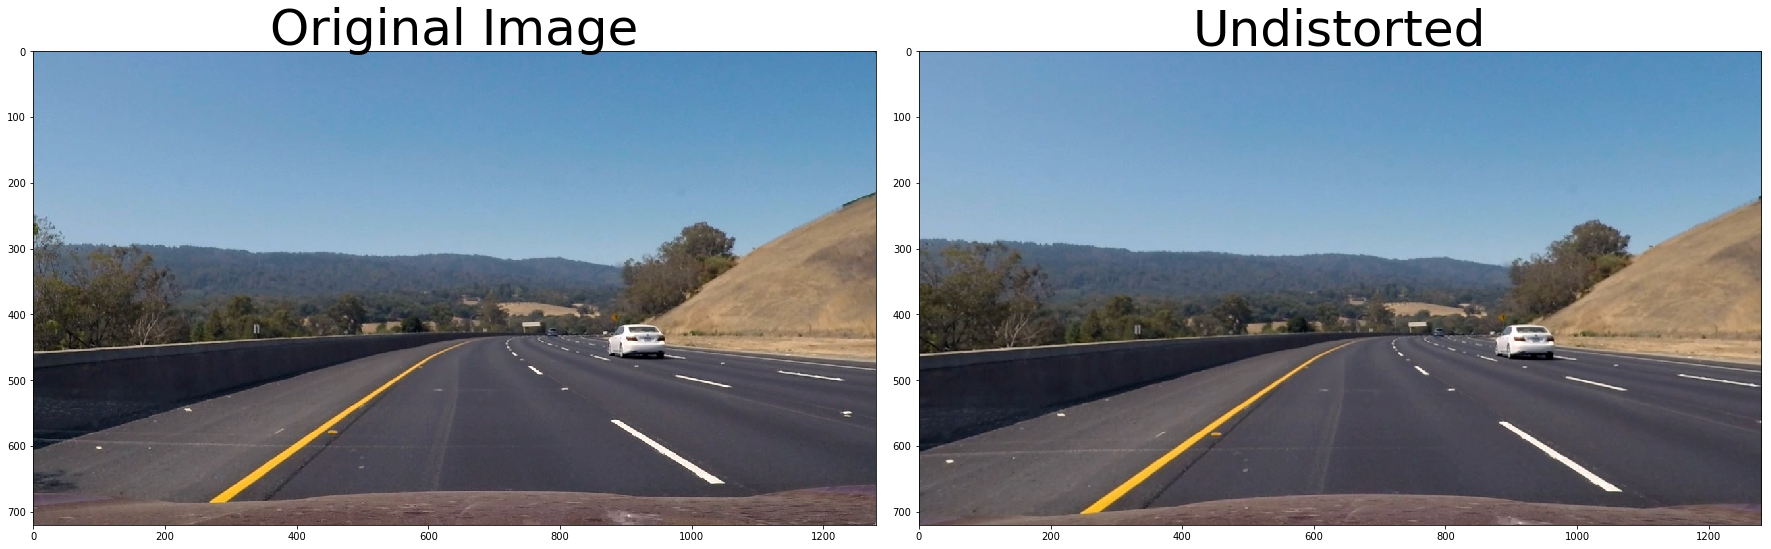

In [145]:
# Read and undistort an image
image = mpimg.imread('test_images/test3.jpg')
undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted, cmap='gray')
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

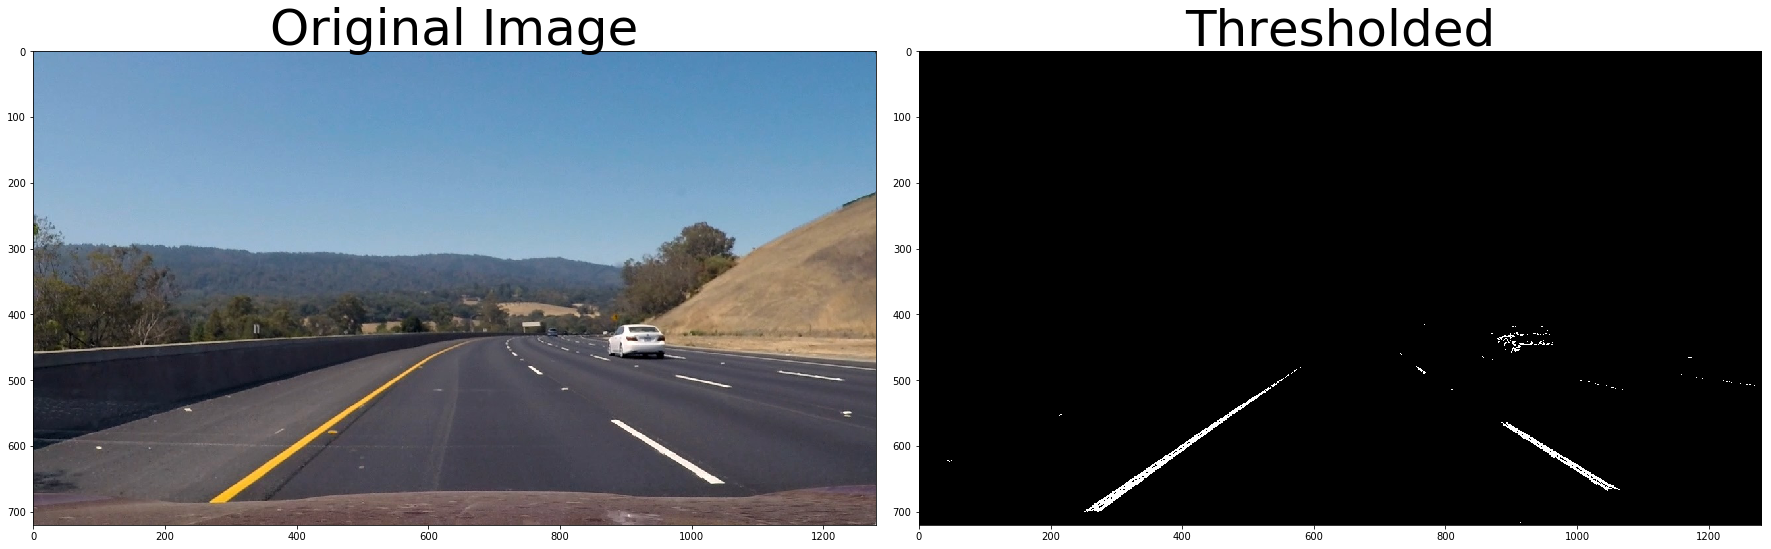

In [146]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
thresholded = threshold_image(undistorted)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform
Identify four source points for all perspective transforms. Use an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

In [109]:
# Read and undistort an image
perspective_image = mpimg.imread('test_images/straight_lines1.jpg')
perspective_image = cv2.undistort(perspective_image, mtx, dist, None, mtx)

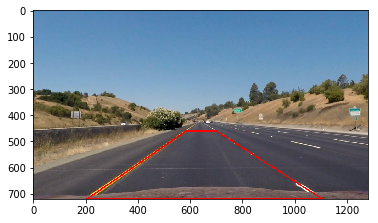

In [110]:
# draw a polygon (trapezoid to be precise)
poly = perspective_image.copy()
pts = np.array([[585, 460], [205, 720], [1105, 720], [700, 460]], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(poly, [pts], True, (255,0,0), 3)
plt.imshow(poly)

In [111]:
src = np.array([[585, 460], [205, 720], [1105, 720], [700, 460]]).astype(np.float32)
dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]]).astype(np.float32)

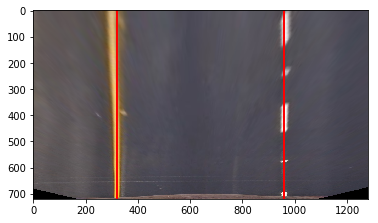

In [112]:
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Compute the inverse one
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image using OpenCV warpPerspective()
warped_test = cv2.warpPerspective(perspective_image, M, (img_shape[1], img_shape[0]))
cv2.line(warped_test, (320,0), (320,720), (255,0,0),5)
cv2.line(warped_test, (960,0), (960,720), (255,0,0),5)
plt.imshow(warped_test)

Now we can use the calculated `M` and `Minv` for future transformation.

## Detect lane lines

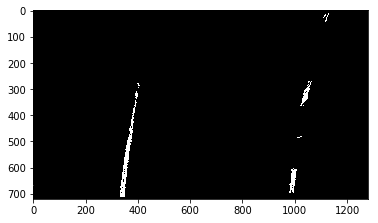

In [147]:
# `thresholded` is the thresholded image
warped = cv2.warpPerspective(thresholded, M, (img_shape[1], img_shape[0]))
plt.imshow(warped, cmap='gray')

In [156]:
def sliding_window(image):
    binary_warped = image.copy()
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [157]:
# use last fit to make a fit for this frame
def skip_sliding_window(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)

    return left_fit_updated, right_fit_updated

In [155]:
# Plot the polygons on the image
def plot_poly_on_orig(left_fit, right_fit, orig):
    # Draw lines from polynomials
    ploty = np.linspace(0, orig.shape[0]-1, orig.shape[0])
    left_fit = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Create an overlay from the lane lines
    overlay = np.zeros_like(orig).astype(np.uint8)
    cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))
    
    # Apply inverse transform to the overlay to plot it on the original road
    overlay = cv2.warpPerspective(overlay, Minv, (overlay.shape[1], overlay.shape[0]))
    
    # Add the overlay to the original unwarped image
    result = cv2.addWeighted(orig, 1, overlay, 0.3, 0)
    return result

In [125]:
def plot_poly_on_thresholded(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

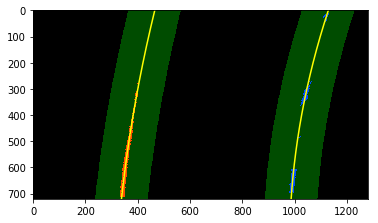

In [148]:
left_fit, right_fit = sliding_window(warped)
plot_poly_on_thresholded(warped, left_fit, right_fit)

## Determine the lane curvature

In [149]:
# Calculate the lane line curvature
def get_curvature(poly_fit, img):
    yscale = 30 / 720  # meters per y pixel
    xscale = 3.7 / 700 # meters per x pixel
    
    # Convert polynomial to set of points for refitting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    fitx = poly_fit[0] * ploty ** 2 + poly_fit[1] * ploty + poly_fit[2]
    
    # Fit new polynomial
    fit_cr = np.polyfit(ploty * yscale, fitx * xscale, 2)
    
    # Calculate curve radius
    curverad = ((1 + (2 * fit_cr[0] * np.max(ploty) * yscale + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
    return curverad

In [151]:
# Calculate the lane curvature radius
l_rad = get_curvature(left_fit, warped)
r_rad = get_curvature(right_fit, warped)

# Get mean of curvatures
rad = np.mean([l_rad, r_rad])
print(rad)

1333.48097707


## Determine the offset

In [158]:
# Find the offset of the car and the base of the lane lines
def find_offset(l_poly, r_poly):
    lane_width = 3.7  # metres
    h = 720  # height of image (index of image bottom)
    w = 1280 # width of image
    
    # Find the bottom pixel of the lane lines
    l_px = l_poly[0] * h ** 2 + l_poly[1] * h + l_poly[2]
    r_px = r_poly[0] * h ** 2 + r_poly[1] * h + r_poly[2]
    
    # Find the number of meters per pixel
    scale = lane_width / np.abs(l_px - r_px)
    
    # Find the midpoint
    midpoint = np.mean([l_px, r_px])
    
    # Find the offset from the centre of the frame, and then multiply by scale
    offset = (w/2 - midpoint) * scale
    return offset

In [159]:
offset = find_offset(left_fit, right_fit) # in meter
print(offset)

-0.127385701285


## Combine all above

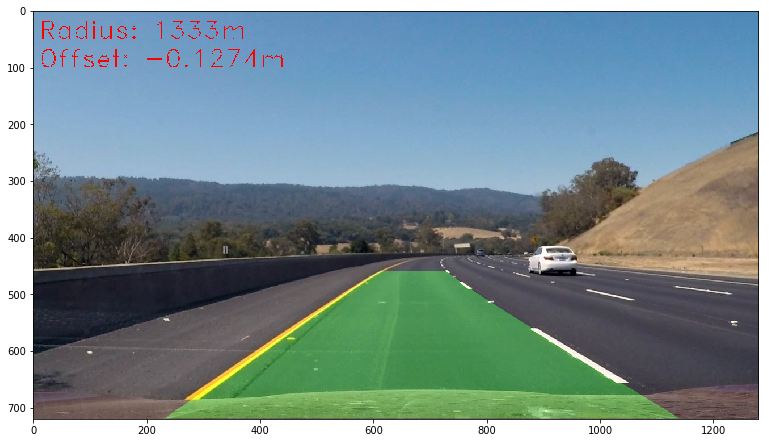

In [200]:
# test it
combined = plot_poly_on_orig(left_fit, right_fit, image)

# Write radius on image
cv2.putText(combined, 'Radius: {}m'.format(int(rad)), (10, 50), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)

# Write lane offset on image
cv2.putText(combined, 'Offset: {}m'.format(round(offset, 4)), (10, 100), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)

# plot it
plt.figure(figsize=(13, 8))
plt.imshow(combined)

## Test on video

#### Combine above to write one function for each frame

In [177]:
# sanity check lanes and curvature
def sanity_check(left_fit, right_fit, last_rad, current_rad):
    xscale = 3.7 / 700 # meters per x pixel
    res = False

    if len(left_fit)>0 and len(right_fit)>0:
        # 1. check if roughly parallel
        # 2. check if two lines in the acceptable range of distances apart
        dist_tolerance = 1. # in meter
        lane_width_max = 4. # in meter
        lane_width_min = 3.3 # in meter
        # top points
        top_x = 460
        top_y_l = left_fit[0]*top_x**2+left_fit[1]*top_x+left_fit[2]
        top_y_r = right_fit[0]*top_x**2+right_fit[1]*top_x+right_fit[2]
        top_d =  np.abs(top_y_r-top_y_l)
        top_d_in_m = top_d*xscale

        # buttom points
        btm_x = 700
        btm_y_l = left_fit[0]*btm_x**2+left_fit[1]*btm_x+left_fit[2]
        btm_y_r = right_fit[0]*btm_x**2+right_fit[1]*btm_x+right_fit[2]
        btm_d =  np.abs(btm_y_r-btm_y_l)
        btm_d_in_m = btm_d*xscale
        
        res = (np.abs(top_d-btm_d)*xscale<=dist_tolerance) \
              & (top_d_in_m<=lane_width_max) & (top_d_in_m>=lane_width_min) \
              & (btm_d_in_m<=lane_width_max) & (btm_d_in_m>=lane_width_min) 

        # 3. check if radius out of range: 100m to 10000m
        res = res & ((rad>=100) & (rad<=10000))
        
        # 4. check if curvature close to the last one
        rad_tolerance = 2000 # in meters
        res = res & (np.abs(current_rad-last_rad)<rad_tolerance)
                
    return res

In [208]:
# store recent fits and make moving average
recent_left_fits, recent_right_fits = [], []
last_rad = 0.0
fail_counter = 0
line_weight = 0.4

def process_frame(img):
    global recent_left_fits, recent_right_fits, last_rad, fail_counter
    
    # Undistort the image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Keep the untransformed image for later
    orig = img.copy()

    # Apply thresholding methods
    thresholded = threshold_image(img)
    
    # perspective transform
    warped = cv2.warpPerspective(thresholded, M, (img_shape[1], img_shape[0]))
    
    # Get the sliding window polynomials
    # process:
    # - use a counter to note how many most recent frames fail the sanity check
    # - if counter == 3, i.e failed in the last 3 frames, use full search; if not, use skip_sliding_window
    # - calculate curvature
    # - sanity check fits and curvature
    # - if fail, use average of last 3 good fits and last rad, counter+1; 
    # - if pass, use weighted average and current rad, counter=0
    # - save fits and move on
    
    if fail_counter==3 or len(recent_left_fits)==0:
        left_fit, right_fit = sliding_window(warped)
    else:
        # use the last GOOD fits
        left_fit, right_fit = skip_sliding_window(recent_left_fits[-1], recent_right_fits[-1], warped)

    # Calculate the curvature
    l_rad = get_curvature(left_fit, warped)
    r_rad = get_curvature(right_fit, warped) 
    # Get mean of curvatures
    rad = np.mean([l_rad, r_rad])
    
    # no sanity check for first frame
    if len(recent_left_fits)>0:
        # sanity check fits and curvature
        sanity_status = sanity_check(left_fit, right_fit, last_rad, rad)

        # if pass
        if sanity_status:
            # calculate weighted average
            left_fit = (1-line_weight) * recent_left_fits[-1] + line_weight * left_fit
            right_fit = (1-line_weight) * recent_right_fits[-1] + line_weight * right_fit
            fail_counter = 0 # reset counter
        else:
            left_fit = np.mean(recent_left_fits, axis=0)
            right_fit = np.mean(recent_right_fits, axis=0)
            rad = last_rad
            fail_counter += 1
    
    # save current fits
    # keep only 3 recent good fits
    if len(recent_left_fits)==3:
        recent_left_fits = recent_left_fits[1:]
        recent_right_fits = recent_right_fits[1:]
    recent_left_fits.append(left_fit)
    recent_right_fits.append(right_fit)


    # Create combined image
    combined = plot_poly_on_orig(left_fit, right_fit, orig)
        
    # Write radius on image
    cv2.putText(combined, 'Lane Radius: {}m'.format(int(rad)), (10, 50), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    
    # Write lane offset on image
    offset = find_offset(left_fit, right_fit)
    cv2.putText(combined, 'Lane Offset: {}m'.format(round(offset, 4)), (10, 100), cv2.FONT_HERSHEY_DUPLEX, 1.5, 255)
    
    return combined

In [209]:
from moviepy.editor import VideoFileClip

project_output = 'out3.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_frame)

%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video out3.mp4
[MoviePy] Writing video out3.mp4


100%|█████████▉| 1260/1261 [04:42<00:00,  4.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out3.mp4 

CPU times: user 6min 29s, sys: 4.81 s, total: 6min 34s
Wall time: 4min 43s


In [210]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('out3.mp4'))